# <span style="color:#1111AA"> Michelson interferometer: Lengths and Tunings </span>

# Table of content

# 1.  Overview

## 1.1. Introduction

The aim of this session is to build a model of a Michelson interferometer, and investigate how its output depends on the macrospical lengths and microscopical tunings of its arms. The Michelson interferometer is the core of the interferometric GW detectors such as LIGO, Virgo, GEO and KAGRA.

## 1.2. Prerequisites and reading material

We recommend that you have done the following notebooks before starting this one:
* [01_01_01_Ipython_notebook](../../01_Introduction/01_01_Ipython_notebook)
* [01_02_01_Pykat](../../01_Introduction/01_02_Pykat/01_02_01_Pykat.ipynb)
* [01_03_01_Finesse](../../01_Introduction/01_03_Finesse/01_03_01_Finesse.ipynb)

or have corresponding basic experience of Ipython notebooks, PyKat, and Finesse. The links above only works if you started ipython notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3).

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf).

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/)

## 1.3. After this session you will be able to...

**After this session you will be able to**:
  * build a FINESSE-model of a Michelson interferometer.
  * calibrate the operating point of the FINESSE-model.

# 2.  Modelling a Michelson Interferometer using FINESSE

## 2.1. Importing packages

We start by loading some necessary packages:

In [1]:
import numpy as np                         # Importing numpy
import matplotlib                          # Importing matplotlib, so we can plot figures
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool.
pykat.init_pykat_plotting(dpi=90)          

                                              ..-
    PyKat 0.8.8           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



## 2.2 Optical Layout

Below is the optical layout of a simple Michelson. The laser beam is splitted by the beam splitter (BS) and propagates in both X and Y arms. Gravitational wave detectors are calibrated such that when the two beams are recombined at the beam splitter, they interfere (close to) destructively at the output port. Mirror movements or gravitational waves change the differential arm lenghth $\Delta L = L_y - L_x$, which produces a signal at the output port where we place a photodiode. See section 5.2 in the review article if you want a longer description of the Michelson interferometer.

In [4]:
from IPython.display import Image
from IPython.core.display import HTML
display(Image(url="files/michelson.png"))

![michelson.png](files/michelson.png)

In [5]:
display(HTML('<img src="files/michelson.png" width=400 height=400/>'))

## 2.3.  Lengths and tunings

If the beams interfere constructively or destructively at the beam splitter depends on the difference in optical path lengths for the two arms, modulo the laser wavelength. Thus, for the light of a Nd:YAG laser ($\lambda = 1064$ nm), length differences of less than 1 μm are of interest. Some orders of magnitude:
  * LIGO peak senitivity in meters: $\sim 10^{-20}$ m
  * LIGO cavity mirror postion control accuracy: $< 10^{-12}$ m
  * LIGO arm cavity length: $\sim 10^3$ m
  * relative numerical accuracy of floating point numbers: $10^{-15}$

Therefore, it is convenient to split distances D between optical components into two parameters: one is the macroscopic ‘length’ L defined now as that multiple of the default wavelength $\lambda_0$ yielding the smallest difference to D. The second parameter is the microscopic tuning that is defined as the remaining difference between L and D. This tuning is usually given as a phase "phi" (in radians) with 2π referring to one wavelength. In FINESSE tunings are entered and printed in degrees, so that a tuning of phi = 360 degrees refers to a change in the position of the component by one wavelength ($\lambda_0$). In FINESSE macroscopical lengths are assigned to space components (keyword `s`) and microscopiacal tunings are assigned to optical components such as mirrors, beam splitters, lenes etc. You can read more about how lengths and tuning are defined in FINESSE in section 2.5 in Freise et al. [1]. 

## 2.4. Building the FINESSE-model

Lets build an optical model in FINESSE matching the setup in the figure above.

In [4]:
basekat = finesse.kat()    # Initialising Finesse
basekat.verbose = False    # Tells Finesse to talk less

basecode = """

## Parameters ##
const Pin 1M         # Laser power [W]
const LX 4000        # Length of X arm [m]
const LY 4000        # Length of Y arm [m]

## Laser & Beam splitter ##
l laser $Pin 0 n0                         # Laser
s s1 1 n0 nbsc                            # Space from laser to beam splitter
bs BS 0.5 0.5 0 45 nbsc nbsY nbsX nbsd    # Central 50/50 beam splitter with 0 tuning and 45 deg angle of incidence.

## X arm ##
s LX $LX nbsX nmX1         # Space between beam splitter and mirror mX
m mX 1 0 0 nmX1 nmX2       # Test mass mirror mX (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Y arm ##
s LY $LY nbsY nmY1         # Space between beam slitter and mirror mY
m mY 1 0 0 nmY1 nmY2       # Test mass mirror mY (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Output port ##
s sout 1 nbsd nout         # Space from BS to a measurement device not yet defined

"""
basekat.parseCommands(basecode)  # passing the input text to the Finesse object

We call this kat-object *basekat* since it describes the core optics of the system we will investigate throughout this notebook. The above basekat-object will not be altered much throughout the Notebooks about the Michelson interferometer, however, what we measure and the specific simulation instructions will. Therefore we can copy the above basekat objet by using `deepcopy`, and then add on the specific simulation instructions.

## 2.5. Differential arm length tuning

Now we add the simulation instrctions. Here we will look at how the output power varies with differential arm length (DARM) tuning. 

In [43]:
kat1 = deepcopy(basekat)
code = """

## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##

# Varying the differential arm length
xaxis mX phi lin -90 90 200      # Changes the parameter phi of mX from -90 to 90 in 200 linear steps. 

put mY phi $mx1                  # Puts the negative (m in $mx1 is keyword for minus) value from the 
                                 # x-axis to the tuning of mY.
yaxis abs                        # Outputs the amplitude of their measured quantity.
"""
# Parsing the FINESSE code
kat1.parseCommands(code)
out1 = kat1.run()

The line `put mY phi $mx1` Parameters with an `$` are internal variables in Finesse with `$mx1` referring to the current value of the xaxis times (-1). Without the `m` in front of `x1` there would be no factor of (-1). The put command sets the position paramter `phi` of mirror `mY` to this value. Therefore, by using the put command here, we elongate one arm while shortening the other. The star * after `put` adds the value `mx1` to the value already set as the tuning of the mirror `mY`, instead of setting the tuning to be exactly `mx1`.

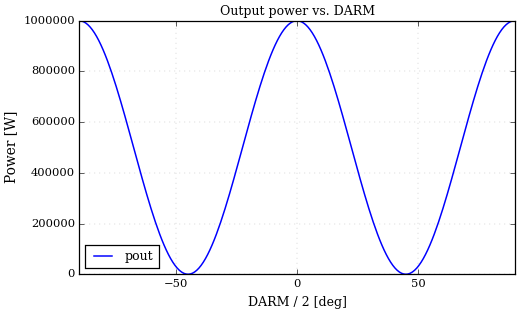

In [44]:
fig1 = out1.plot(xlabel="DARM / 2 [deg]", 
                 ylabel="Power [W]", 
                 title="Output power vs. DARM")

## 2.4. Simulation output:

In [6]:
out1 = kat1.run() # run Finesse, the output will be stored in 'out1'

The result of the run is now stored in the object `out1`. We can plot the output by using:

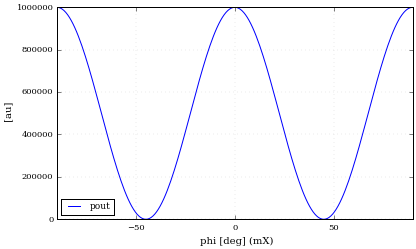

In [7]:
fig1 = out1.plot()

To add units on the y-axis we can use:

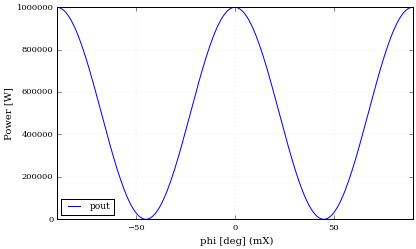

In [8]:
fig1b = out1.plot(show=False)
fig1b.axes[0].set_ylabel('Power [W]')
plt.show(fig1b)

# 3. Your tasks: 

## 3.1. Calibrate the operating point

We currently have a power peak for zero differential arm length tuning. Change **one** parameter in the setup to make zero differential arm length tuning yield zero power. Save this parameter in `basekat`. Discuss why we want to operate at, or close to, the dark fringe?

**Answer:**

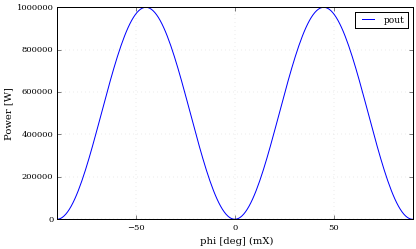

In [9]:
kat2 = deepcopy(kat1)
kat2.mY.phi = 90
out2 = kat2.run() # run Finesse, the output will be stored in 'out'
fig2 = out2.plot(show=False)
fig2.axes[0].set_ylabel('Power [W]')
plt.show(fig2)

## 3.2. Question about operating point 

By looking at how the detected power changes as a function of differential arm length tuning (mimics GW signal), try to answer why we cannot operate exactly at the dark fringe?  *Hint: See sections 4 and 5.4 in the review article.*

** Answer: **

* We need a local oscillator to amplify the gravitational wave signal. More on this later.
* To control the differential arm length we need $\mathrm{d}P/\mathrm{d}\phi \neq 0$ at the operating point.

## 3.3. Setting the operating point

Change the tuning slightly of one of the arm mirrors so that we get 10 mW as output, and save this detuning in `basekat`. What length offset does this tuning offset corresponds to? Why not a larger number than 10 mW?

**Comment**: In case you want to use a <a href="http://docs.scipy.org/doc/scipy/reference/optimize.html">`scipy.optimize`</a> tool (I would suggest `scipy.optimize.minimize_scalar()` in that case), Finesse can be told to compute results for one data point per run by setting `kat.noxaxis=True`.

**Answer:**

In [10]:
kat3 = deepcopy(basekat)
# Adding photo diode
kat3.parseCommands('pd pout nout')
# Using no x-axis, meaning only one value will be computed.
kat3.noxaxis = True

def f(x):
    kat3.mY.phi = x
    out3 = kat3.run()
    print('Tuning: {0} \t \t Power: {1}'.format(x, out3['pout']))
    # print(out['pout'],x,np.abs(out['pout'] - 0.01), kat.mY.phi.value)
    return np.abs(out3['pout'] - 0.01)

import scipy.optimize as op

#help(op.minimize_scalar)
sol = op.minimize_scalar(f,method='Bounded',bounds=(89,91))
print(sol)
detuning = sol.x
basekat.mY.phi = detuning

print('Detuning: {:.3f} pm'.format(1.0e12*(detuning-90)*kat3.lambda0/360.0))

Tuning: 89.76393202250021 	 	 Power: 16.9756509272533
Tuning: 90.23606797749979 	 	 Power: 16.9756509272523
Tuning: 90.52786404500041 	 	 Power: 84.8763334891159
Tuning: 90.0 	 	 Power: 3.74939945665464e-27
Tuning: 90.00000466824906 	 	 Power: 6.63839011767411e-09
Tuning: 90.0000093364982 	 	 Power: 2.65535609248452e-08
Tuning: 90.09017571402269 	 	 Power: 2.47704305961049
Tuning: 90.0344498280701 	 	 Power: 0.361517063301683
Tuning: 90.01316443368941 	 	 Power: 0.0527909029152963
Tuning: 90.00503413649993 	 	 Power: 0.00771977617097237
Tuning: 90.00813963368768 	 	 Power: 0.020182011687528
Tuning: 90.00311483368594 	 	 Power: 0.00295545574337605
Tuning: 90.00622033087369 	 	 Power: 0.0117864143969354
Tuning: 90.005940108013 	 	 Power: 0.010748390041197
Tuning: 90.00567299830594 	 	 Power: 0.00980347490610781
Tuning: 90.00542897481016 	 	 Power: 0.00897822297713017
Tuning: 90.00570963238332 	 	 Power: 0.00993049798522599
Tuning: 90.0057635257286 	 	 Power: 0.0101188511201952
Tuning: 90

# 4. Extra if you have time. 

## 4.1. Question about assymetry 

**(a)** Exploring asymmetry, change the beam splitter to be not 50:50. Run the above simulatin again but with different reflectivities for the beam splitter. Plot the results and describe the effects of the BS asymmetry on Michelson output signal. Hint: use for example `kat.BS.R = 0.7` and `kat.BS.T = 0.3` to set it to a 70:30 beam splitter.

**Answer:**

In [11]:
kat4 = deepcopy(basekat)
code = '''
pd pout nbsd                     # Photo diode at the dark port

ad Xarm 0 nbsX*
ad Yarm 0 nbsY*

xaxis mX phi lin -60 60 200
put* mY phi $mx1

yaxis abs
'''

kat4.parseKatCode(code)
kat4.BS.R=0.2
kat4.BS.T=0.8
out4a = kat4.run()
kat4.BS.R=0.4
kat4.BS.T=0.6
out4b = kat4.run()
kat4.BS.R=0.6
kat4.BS.T=0.4
out4c = kat4.run()
kat4.BS.R=0.8
kat4.BS.T=0.2
out4d = kat4.run()

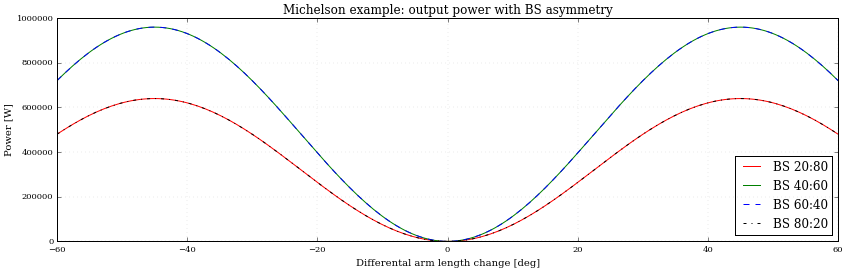

In [12]:
plt.figure(figsize=(14,4))
plt.plot(out4a.x,out4a['pout'],'-', color='r',label='BS 20:80')
plt.plot(out4b.x,out4b['pout'],'-', color = 'g', label='BS 40:60')
plt.plot(out4c.x,out4c['pout'],'--',color='b', label='BS 60:40')
plt.plot(out4d.x,out4d['pout'],'-.',color='k', label='BS 80:20')
plt.title(r'Michelson example: output power with BS asymmetry')
plt.xlabel('Differental arm length change [deg]')
plt.xlim([min(out4a.x),max(out4a.x)])
plt.legend(loc=4)
plt.ylabel('Power [W]')
plt.grid(True)

**(b)** Exploring asymmetry: change the reflectivity of the mX end mirror and run the simulation again.

** Answer: **

In [13]:
kat5 = deepcopy(basekat)
code = """
pd pout nbsd

ad Xarm 0 nbsX*
ad Yarm 0 nbsY*

xaxis mX phi lin -60 60 200
put* mY phi $mx1

yaxis abs
"""
kat5.parseKatCode(code)
kat5.mX.R=1
out5a = kat5.run()
kat.mX.R=0.6
out5b = kat5.run()
kat5.mX.R=0.1
out5c = kat5.run()
kat5.mX.R=0.0
out5d = kat5.run()

NameError: name 'kat' is not defined

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(out5a.x,out5a['pout'],'-', color = 'r', label='mX R=1.0')
plt.plot(out5b.x,out5b['pout'],'-', color = 'g', label='mX R=0.6')
plt.plot(out5c.x,out5c['pout'],'--',color = 'b', label='mX R=0.1')
plt.plot(out5d.x,out5d['pout'],'-.',color = 'k', label='mX R=0.0')
plt.title(r'Michelson example: output power with different mX reflextivies')
plt.xlabel('Differental arm length change [deg]')
plt.xlim([min(out5a.x),max(out5a.x)])
plt.legend(loc=1)
plt.ylabel('Power [W]')
plt.grid(True)

In [15]:
show_finesse(kat5)

% Generated by PyKat 08.01.2016 14:08:26

l l1 1000000.0 0.0 0.0 n0
s s1 1.0 n0 nbsc
bs BS 0.5 0.5 0.0 45.0 nbsc nbsY nbsX nbsd
s LX 4000.0 nbsX nmX1
m mX 1.0 0.0 0.0 nmX1 nmX2
s LY 4000.08 nbsY nmY1
m mY 1.0 0.0 90.00572712278269 nmY1 nmY2
s sout 1.0 nbsd nout
pd0 pout nbsd
ad Xarm 0 nbsX*
ad Yarm 0 nbsY*
xaxis mX phi lin -60 60 200
put* mY phi $mx1
yaxis lin abs
